# AdaBoost的Python实现

# 数据集可视化

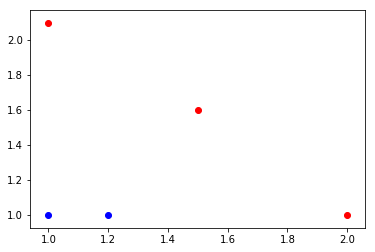

In [3]:
#数据集可视化
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#数据集
def loadSimpData():
    datMat = np.matrix([
        [ 1. ,  2.1],
        [ 1.5,  1.6],
        [ 1.2,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

#数据可视化
def showDataSet(dataMat, labelMat):
    data_plus = []                                  #正样本
    data_minus = []                                 #负样本
    for i in range(len(dataMat)):
        if labelMat[i] > 0:
            data_plus.append(dataMat[i])
        else:
            data_minus.append(dataMat[i])
    data_plus_np = np.array(data_plus)                                             #转换为numpy矩阵
    data_minus_np = np.array(data_minus)                                         #转换为numpy矩阵
    plt.scatter(np.transpose(data_plus_np)[0], np.transpose(data_plus_np)[1],c='r')        #正样本散点图
    plt.scatter(np.transpose(data_minus_np)[0], np.transpose(data_minus_np)[1],c='b')     #负样本散点图
    plt.show()
 
if __name__ == '__main__':
    dataArr,classLabels = loadSimpData()
    showDataSet(dataArr,classLabels)

# 构建单层决策树

In [4]:
#构建单层决策树
import numpy as np
import matplotlib.pyplot as plt

#单层决策树分类函数
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):
    """
    单层决策树分类函数
    Parameters:
        dataMatrix - 数据矩阵
        dimen - 第dimen列，也就是第几个特征
        threshVal - 阈值
        threshIneq - 标志
    Returns:
        retArray - 分类结果
    """
    retArray = np.ones((np.shape(dataMatrix)[0],1))                #初始化retArray为1
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0         #如果小于阈值,则赋值为-1
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0         #如果大于阈值,则赋值为-1
    return retArray
    
def buildStump(dataArr,classLabels,D):
    """
    找到数据集上最佳的单层决策树
    Parameters:
        dataArr - 数据矩阵
        classLabels - 数据标签
        D - 样本权重
    Returns:
        bestStump - 最佳单层决策树信息
        minError - 最小误差
        bestClasEst - 最佳的分类结果
    """
    dataMatrix = np.mat(dataArr); labelMat = np.mat(classLabels).T
    m,n = np.shape(dataMatrix)
    numSteps = 10.0; bestStump = {}; bestClasEst = np.mat(np.zeros((m,1)))
    minError = float('inf')              #最小误差初始化为正无穷大
    for i in range(n):                                                            #遍历所有特征
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max()        #找到特征中最小的值和最大值
        stepSize = (rangeMax - rangeMin) / numSteps                                #计算步长
        for j in range(-1, int(numSteps) + 1):                                     
            for inequal in ['lt', 'gt']:  #lees than  great than               #大于和小于的情况，均遍历。lt:less than，gt:greater than
                threshVal = (rangeMin + float(j) * stepSize)                     #计算阈值
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)#计算分类结果
                errArr = np.mat(np.ones((m,1)))                                 #初始化误差矩阵
                errArr[predictedVals == labelMat] = 0                             #分类正确的,赋值为0
                weightedError = D.T * errArr                           #计算误差
                #print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                if weightedError < minError:                                     #找到误差最小的分类方式
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst

if __name__ == '__main__':
    dataArr,classLabels = loadSimpData()
    D = np.mat(np.ones((5, 1)) / 5)
    bestStump,minError,bestClasEst = buildStump(dataArr,classLabels,D)
    print('bestStump:\n', bestStump)
    print('minError:\n', minError)
    print('bestClasEst:\n', bestClasEst)

bestStump:
 {'dim': 0, 'thresh': 1.2, 'ineq': 'lt'}
minError:
 [[0.2]]
bestClasEst:
 [[-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]]


# 训练多个弱分类器

In [5]:
#训练多个弱分类器
import numpy as np
import matplotlib.pyplot as plt
def adaBoostTrainDS(dataArr, classLabels, numIt = 40):
    weakClassArr = []
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m, 1)) / m)                         #初始化权重
    aggClassEst = np.mat(np.zeros((m,1)))        
    for i in range(numIt):#最大的弱学习器书目
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)     #构建单层决策树
        print("D:",D.T)
        alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16)))         #计算弱学习算法权重alpha,使error不等于0,因为分母不能为0
        bestStump['alpha'] = alpha                                          #存储弱学习算法权重
        weakClassArr.append(bestStump)                                      #存储单层决策树
        print("classEst: ", classEst.T)
        expon = np.multiply(-1 * alpha * np.mat(classLabels).T, classEst)     #计算e的指数项
        D = np.multiply(D, np.exp(expon))                                      
        D = D / D.sum()                       #根据样本权重公式，更新样本权重
        #计算AdaBoost误差，当误差为0的时候，退出循环
        aggClassEst += alpha * classEst                                 
        print("aggClassEst: ", aggClassEst.T)
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m,1)))     #计算误差
        errorRate = aggErrors.sum() / m
        print("total error: ", errorRate)
        if errorRate == 0.0: 
            break                                             #误差为0，退出循环
    return weakClassArr, aggClassEst

if __name__ == '__main__':
    dataArr,classLabels = loadSimpData()
    weakClassArr, aggClassEst = adaBoostTrainDS(dataArr, classLabels)
    print(weakClassArr)
    print(aggClassEst)

D: [[0.2 0.2 0.2 0.2 0.2]]
classEst:  [[-1.  1. -1. -1.  1.]]
aggClassEst:  [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error:  0.2
D: [[0.5   0.125 0.125 0.125 0.125]]
classEst:  [[ 1.  1. -1. -1. -1.]]
aggClassEst:  [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error:  0.2
D: [[0.28571429 0.07142857 0.07142857 0.07142857 0.5       ]]
classEst:  [[1. 1. 1. 1. 1.]]
aggClassEst:  [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error:  0.0
[{'dim': 0, 'thresh': 1.2, 'ineq': 'lt', 'alpha': 0.6931471805599453}, {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565}, {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}]
[[ 1.17568763]
 [ 2.56198199]
 [-0.77022252]
 [-0.77022252]
 [ 0.61607184]]


# 使用AdaBoost提升分类器性能

In [6]:
#使用AdaBoost提升分类器性能
import numpy as np
import matplotlib.pyplot as plt
def adaClassify(datToClass,classifierArr):
    """
    AdaBoost分类函数
    Parameters:
        datToClass - 待分类样例
        classifierArr - 训练好的分类器
    Returns:
        分类结果
    """
    dataMatrix = np.mat(datToClass)
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(len(classifierArr)):                                        #遍历所有分类器，进行分类
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'], classifierArr[i]['thresh'], classifierArr[i]['ineq'])            
        aggClassEst += classifierArr[i]['alpha'] * classEst
        print(aggClassEst)
    return np.sign(aggClassEst)
if __name__ == '__main__':
    dataArr,classLabels = loadSimpData()
    weakClassArr, aggClassEst = adaBoostTrainDS(dataArr, classLabels)
    print(adaClassify([[0,0],[5,5]], weakClassArr))

D: [[0.2 0.2 0.2 0.2 0.2]]
classEst:  [[-1.  1. -1. -1.  1.]]
aggClassEst:  [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error:  0.2
D: [[0.5   0.125 0.125 0.125 0.125]]
classEst:  [[ 1.  1. -1. -1. -1.]]
aggClassEst:  [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error:  0.2
D: [[0.28571429 0.07142857 0.07142857 0.07142857 0.5       ]]
classEst:  [[1. 1. 1. 1. 1.]]
aggClassEst:  [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error:  0.0
[[-0.69314718]
 [ 0.69314718]]
[[-1.66610226]
 [ 1.66610226]]
[[-2.56198199]
 [ 2.56198199]]
[[-1.]
 [ 1.]]


# 病马死亡率预测

In [5]:
# -*-coding:utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.chdir('C:\\Users\\CDA\\data')

def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):
    retArray = np.ones((np.shape(dataMatrix)[0],1))                #初始化retArray为1
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0         #如果小于阈值,则赋值为-1
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0         #如果大于阈值,则赋值为-1
    return retArray
    
def buildStump(dataArr,classLabels,D):
    dataMatrix = np.mat(dataArr); labelMat = np.mat(classLabels).T
    m,n = np.shape(dataMatrix)
    numSteps = 10.0; bestStump = {}; bestClasEst = np.mat(np.zeros((m,1)))
    minError = float('inf')                                                        #最小误差初始化为正无穷大
    for i in range(n):                                                            #遍历所有特征
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max()        #找到特征中最小的值和最大值
        stepSize = (rangeMax - rangeMin) / numSteps                                #计算步长
        for j in range(-1, int(numSteps) + 1):                                     
            for inequal in ['lt', 'gt']:                                          #大于和小于的情况，均遍历。lt:less than，gt:greater than
                threshVal = (rangeMin + float(j) * stepSize)                     #计算阈值
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)#计算分类结果
                errArr = np.mat(np.ones((m,1)))                                 #初始化误差矩阵
                errArr[predictedVals == labelMat] = 0                             #分类正确的,赋值为0
                weightedError = D.T * errArr                                      #计算误差
                # print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                if weightedError < minError:                                     #找到误差最小的分类方式
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump, minError, bestClasEst

def adaBoostTrainDS(dataArr, classLabels, numIt = 50):
    """
    使用AdaBoost算法提升弱分类器性能
    Parameters:
        dataArr - 数据矩阵
        classLabels - 数据标签
        numIt - 最大迭代次数
    Returns:
        weakClassArr - 训练好的分类器
        aggClassEst - 类别估计累计值
    """
    weakClassArr = []
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m, 1)) / m)                                            #初始化权重
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(numIt):
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)     #构建单层决策树
        # print("D:",D.T)
        alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16)))         #计算弱学习算法权重alpha,使error不等于0,因为分母不能为0
        bestStump['alpha'] = alpha                                          #存储弱学习算法权重
        weakClassArr.append(bestStump)                                      #存储单层决策树
        # print("classEst: ", classEst.T)
        expon = np.multiply(-1 * alpha * np.mat(classLabels).T, classEst)     #计算e的指数项
        D = np.multiply(D, np.exp(expon))                                      
        D = D / D.sum()                                                        #根据样本权重公式，更新样本权重
        #计算AdaBoost误差，当误差为0的时候，退出循环
        aggClassEst += alpha * classEst                                      #计算类别估计累计值                                
        # print("aggClassEst: ", aggClassEst.T)
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m,1)))     #计算误差
        errorRate = aggErrors.sum() / m
        # print("total error: ", errorRate)
        if errorRate == 0.0: 
            break                                             #误差为0，退出循环
    return weakClassArr, aggClassEst

def adaClassify(datToClass,classifierArr):
    """
    AdaBoost分类函数
    Parameters:
        datToClass - 待分类样例
        classifierArr - 训练好的分类器
    Returns:
        分类结果
    """
    dataMatrix = np.mat(datToClass)
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(len(classifierArr)):                                        #遍历所有分类器，进行分类
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'], classifierArr[i]['thresh'], classifierArr[i]['ineq'])            
        aggClassEst += classifierArr[i]['alpha'] * classEst
        # print(aggClassEst)
    return np.sign(aggClassEst)

if __name__ == '__main__':
    train_data=pd.read_table("horseColicTraining.txt",sep='	',names=range(22))
    trainingSet=train_data.iloc[:,0:21].values.tolist()
    trainingLabels=train_data[21].values.tolist()
    weakClassArr, aggClassEst = adaBoostTrainDS(trainingSet, trainingLabels)
    
    test_data=pd.read_table("horseColicTest.txt",sep='	',names=range(22))
    testSet=test_data.iloc[:,0:21].values.tolist()
    testLabels=test_data[21].values.tolist()
    
    #print(weakClassArr)
    predictions = adaClassify(trainingSet, weakClassArr)#执行分类
    errArr = np.mat(np.ones((len(trainingSet), 1)))
    print('训练集的错误率:%.3f%%' % float(errArr[predictions != np.mat(trainingLabels).T].sum() / len(trainingSet) * 100))
    predictions = adaClassify(testSet, weakClassArr)
    errArr = np.mat(np.ones((len(testSet), 1)))
    print('测试集的错误率:%.3f%%' % float(errArr[predictions != np.mat(testLabels).T].sum() / len(testSet) * 100))

训练集的错误率:40.468%
测试集的错误率:29.851%


# sklearn中的adboost

# 鸢尾花

In [8]:
#鸢尾花
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

iris = load_iris()
clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf, iris.data, iris.target, cv=5)
scores.mean()    

0.9466666666666665

In [11]:
scores

array([0.96666667, 0.93333333, 0.93333333, 0.9       , 1.        ])

# Adaboost预测病马死亡率

In [7]:
#Adaboost预测病马死亡率
import numpy as np
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
train_data=pd.read_table("horseColicTraining.txt",sep='	',names=range(22))
trainingSet=train_data.iloc[:,0:21]
trainingLabels=train_data.iloc[:,21:]

test_data=pd.read_table("horseColicTest.txt",sep='	')
testSet=test_data.iloc[:,0:21]
testLabels=test_data.iloc[:,21:]


bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), algorithm = "SAMME", n_estimators = 50)
bdt.fit(trainingSet, trainingLabels)
predicted = bdt.predict(testSet)

print(metrics.classification_report(testLabels, predicted))
print(metrics.confusion_matrix(testLabels, predicted))
print('The accuracy of Adaboost is :',accuracy_score(testLabels,predicted))

              precision    recall  f1-score   support

           0       0.67      0.70      0.68        20
           1       0.87      0.85      0.86        46

   micro avg       0.80      0.80      0.80        66
   macro avg       0.77      0.77      0.77        66
weighted avg       0.81      0.80      0.80        66

[[14  6]
 [ 7 39]]
The accuracy of Adaboost is : 0.803030303030303


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# 决策树模型

In [10]:
#决策树模型
import numpy as np
import pandas as pd
import os
os.chdir('C:\\Users\\CDA\data')
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
train_data=pd.read_table("horseColicTraining.txt",sep='	',names=range(22))
trainingSet=train_data.iloc[:,0:21]
trainingLabels=train_data.iloc[:,21:]

test_data=pd.read_table("horseColicTest.txt",sep='	')
testSet=test_data.iloc[:,0:21]
testLabels=test_data.iloc[:,21:]

dtree = tree.DecisionTreeClassifier(max_depth=5)

# 输入数据建立模型
dtree.fit(trainingSet, trainingLabels)
predicted = dtree.predict(testSet)
print(metrics.classification_report(testLabels, predicted))
print(metrics.confusion_matrix(testLabels, predicted))
print('The accuracy of dtree is :',accuracy_score(testLabels,predicted))

              precision    recall  f1-score   support

           0       0.50      0.55      0.52        20
           1       0.80      0.76      0.78        46

   micro avg       0.70      0.70      0.70        66
   macro avg       0.65      0.66      0.65        66
weighted avg       0.71      0.70      0.70        66

[[11  9]
 [11 35]]
The accuracy of dtree is : 0.696969696969697


# 逻辑回归病马死亡率

In [11]:
#逻辑回归病马死亡率
import os
os.chdir('C:\\Users\\CDA\\data')
import pandas as pd
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
train_data=pd.read_table("horseColicTraining.txt",sep='	',names=range(22))
trainingSet=train_data.iloc[:,0:21]
trainingLabels=train_data.iloc[:,21:]

test_data=pd.read_table("horseColicTest.txt",sep='	')
testSet=test_data.iloc[:,0:21]
testLabels=test_data.iloc[:,21:]
classifier = LogisticRegression(solver='lbfgs',max_iter=100).fit(trainingSet.values, trainingLabels.values)
predicted=classifier.predict(testSet)

print(metrics.classification_report(testLabels, predicted))
print(metrics.confusion_matrix(testLabels, predicted))
print('The accuracy of logistic is :',accuracy_score(testLabels,predicted))

             precision    recall  f1-score   support

          0       0.54      0.65      0.59        20
          1       0.83      0.76      0.80        46

avg / total       0.74      0.73      0.73        66

[[13  7]
 [11 35]]
The accuracy of logistic is : 0.7272727272727273


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# 随机森林

In [12]:
#随机森林预测病马死亡率
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
train_data=pd.read_table("horseColicTraining.txt",sep='	',names=range(22))
trainingSet=train_data.iloc[:,0:21]
trainingLabels=train_data.iloc[:,21:]

test_data=pd.read_table("horseColicTest.txt",sep='	')
testSet=test_data.iloc[:,0:21]
testLabels=test_data.iloc[:,21:]

RF = RandomForestClassifier(n_estimators=10,max_features=3,min_samples_leaf=10)
RF.fit(trainingSet, trainingLabels)

predicted = RF.predict(testSet)

print(metrics.classification_report(testLabels, predicted))
print(metrics.confusion_matrix(testLabels, predicted))
print('The accuracy of RF is :',accuracy_score(testLabels,predicted))

             precision    recall  f1-score   support

          0       0.58      0.55      0.56        20
          1       0.81      0.83      0.82        46

avg / total       0.74      0.74      0.74        66

[[11  9]
 [ 8 38]]
The accuracy of RF is : 0.7424242424242424


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


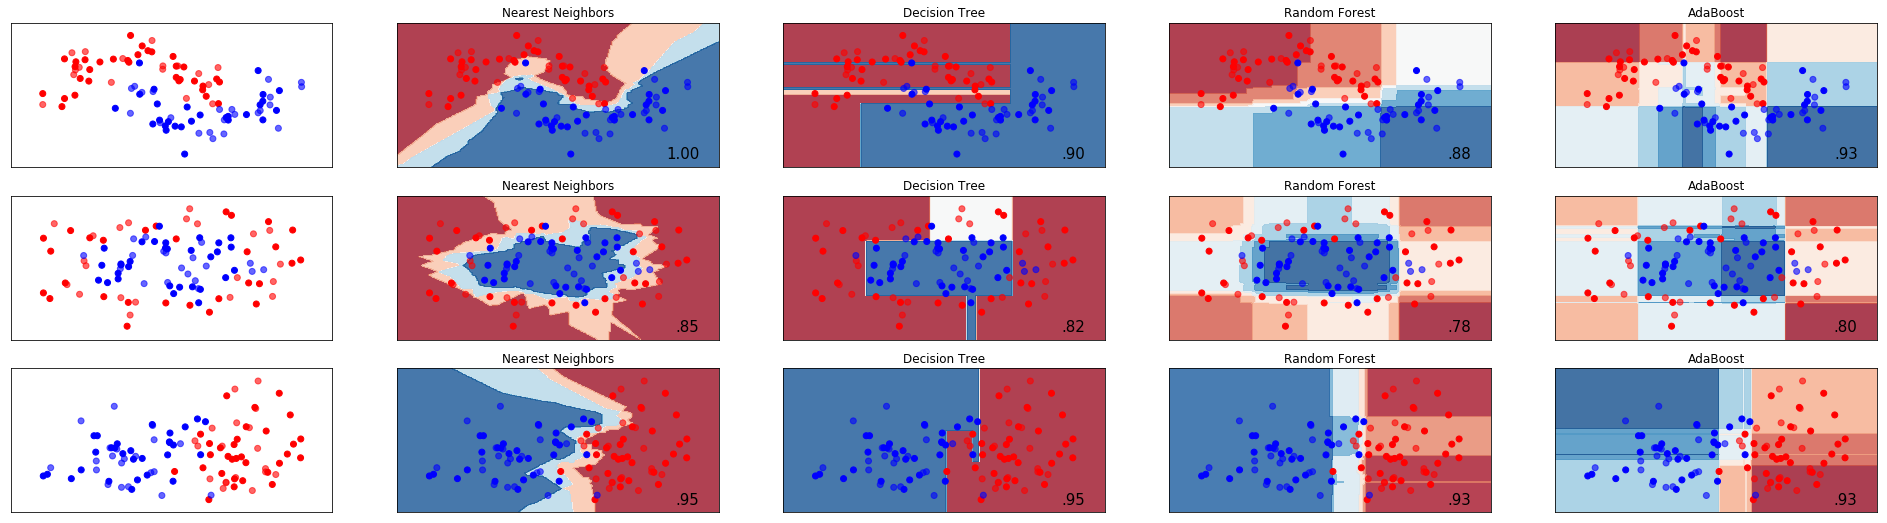

In [75]:
#几种算法比较
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Decision Tree","Random Forest", "AdaBoost"]
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=2, n_estimators=50, max_features=1),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1))]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.2, random_state=1),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds in datasets:
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

figure.subplots_adjust(left=.02, right=.98)
plt.show()


# Stacking

In [5]:
from sklearn import model_selection  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from mlxtend.classifier import StackingClassifier 
import numpy as np,pandas as pd
import os
os.chdir('C:\\Users\\CDA\\data')
import warnings
warnings.filterwarnings("ignore")


train_data=pd.read_table("horseColicTraining.txt",sep='	',names=range(22))
x_data=train_data.iloc[:,0:21]
y_data=train_data.iloc[:,21:]

# 定义三个不同的分类器
clf1 = KNeighborsClassifier(n_neighbors=1)  
clf2 = DecisionTreeClassifier() 
clf3 = LogisticRegression()  

sclf1 = VotingClassifier([('knn',clf1),('dtree',clf2), ('lr',clf3)])   #投票
# # 定义一个次级分类器
meta = LogisticRegression()  
sclf2 = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=meta)#两层
  
for clf, label in zip([clf1, clf2, clf3, sclf1, sclf2],
                      ['KNN','Decision Tree','Logistic Regression','voting', 'StackingClassifier']):  
  
    scores = model_selection.cross_val_score(clf, x_data, y_data, cv=3, scoring='accuracy')  
    print("Accuracy: %0.2f [%s]" % (scores.mean(), label)) 

Accuracy: 0.65 [KNN]
Accuracy: 0.67 [Decision Tree]
Accuracy: 0.67 [Logistic Regression]
Accuracy: 0.67 [voting]
Accuracy: 0.66 [StackingClassifier]
